In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import *
from metal.analysis import confusion_matrix
from metal.utils import convert_labels
from tagger import Tagger

### Load Data

In [2]:
task_name = 'SST2'
split = 'dev'
filepath = f'/dfs/scratch0/chami/metal/metal/mmtl/debugging/errors/03_12_19/{task_name}_{split}_error_analysis.tsv'
df_error = load_dataframe(filepath)

### View Errors

Plotting probabilities from the first column of Y_probs


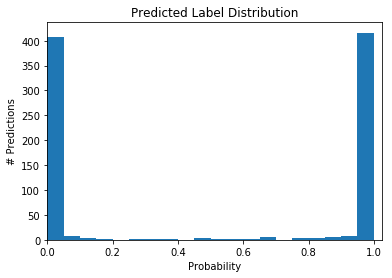

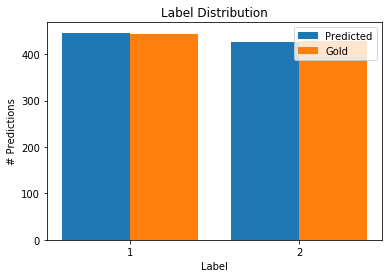

Plotting probabilities from the first column of Y_probs


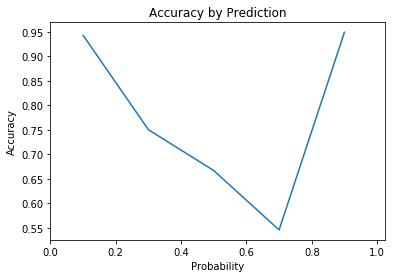

In [14]:
Y_gold = convert_labels(df_error['label'].values, "onezero", "categorical")
Y_preds = convert_labels(df_error['pred'].values, "onezero", "categorical")
Y_probs = np.vstack([df_error['score'].values, 1 - df_error['score'].values]).transpose()

from metal.contrib.visualization.analysis import (
        plot_predictions_histogram, 
        plot_probabilities_histogram,
        plot_calibration_plot
    )
plot_probabilities_histogram(Y_probs, title="Predicted Label Distribution")
plot_predictions_histogram(Y_preds, Y_gold, title="Label Distribution")
plot_calibration_plot(Y_probs, Y_gold, title="Accuracy by Prediction", bins=5)

In [21]:
# print("\033[1mBARELY RIGHT\033[0;0m")
# print_barely_right(df_error, thresh=0.2, n=1)
# print("\033[1mBARELY WRONG\033[0;0m")
# print_barely_wrong(df_error, thresh=0.2, n=1)
print("\033[1mVERY WRONG\033[0;0m")
print_very_wrong(df_error, thresh=0.8, n=10)

VERY WRONG
46 matches were found with the given criteria.

UID:  SST-2/dev.tsv:449
sentence1: 	 generally , clocks ##top ##pers will fulfill your wilde ##st fantasies about being a different kind of time traveler , while happily killing 94 minutes . 
sentence2: 	nan
score: 	0.0273
label: 	1

UID:  SST-2/dev.tsv:120
sentence1: 	 every nano ##se ##con ##d of the the new guy reminds you that you could be doing something else far more pleas ##urable . 
sentence2: 	nan
score: 	0.9998
label: 	0

UID:  SST-2/dev.tsv:97
sentence1: 	 this ri ##vet ##ing world war ii moral suspense story deals with the shadow side of american culture : racial prejudice in its ugly and diverse forms . 
sentence2: 	nan
score: 	0.9998
label: 	0

UID:  SST-2/dev.tsv:22
sentence1: 	 pumpkin takes an ad ##mir ##able look at the h ##yp ##oc ##ris ##y of political correct ##ness , but it does so with such an uneven tone that you never know when humor ends and tragedy begins . 
sentence2: 	nan
score: 	0.9942
label: 	0

U

In [ ]:
i = np.random.randint(df_error.shape[0])
row = df_error.iloc[1]
print('sentence 1: ', row.sentence1.replace(" ##", ""))
print('sentence 2: ', str(row.sentence2).replace(" ##", ""))
print()
print('label: ', row.label)
print('score: ', row.score)
print('uid: ', row.uid)

In [3]:
tagger = Tagger(tags_dir='slices')
tagger.get_examples('SST2_dev_while')

[('SST-2/dev.tsv:29',
  {'sent1': "it 's an offbeat treat that pokes fun at the democratic exercise while also examining its significance for those who take part . ",
   'sent2': None,
   'label': '1'}),
 ('SST-2/dev.tsv:116',
  {'sent1': "it haunts you , you ca n't forget it , you admire its conception and are able to resolve some of the confusions you had while watching it . ",
   'sent2': None,
   'label': '1'}),
 ('SST-2/dev.tsv:146',
  {'sent1': 'while ( hill ) has learned new tricks , the tricks alone are not enough to salvage this lifeless boxing film . ',
   'sent2': None,
   'label': '0'}),
 ('SST-2/dev.tsv:284',
  {'sent1': "while there 's something intrinsically funny about sir anthony hopkins saying ` get in the car , bitch , ' this jerry bruckheimer production has little else to offer ",
   'sent2': None,
   'label': '1'}),
 ('SST-2/dev.tsv:368',
  {'sent1': 'altogether , this is successful as a film , while at the same time being a most touching reconsideration of the fam

# Slicing

In [17]:
model_path = ''
task_name = 'SST2'
split = 'dev'
# multi task
filepath = f'/dfs/scratch0/chami/metal/metal/mmtl/debugging/errors/03_12_19/{task_name}_{split}_error_analysis.tsv'
# single task
# filepath = f'{task_name}_{split}_error_analysis.tsv'
print(filepath)
df_error = load_dataframe(filepath)
df_error.head()

/dfs/scratch0/chami/metal/metal/mmtl/debugging/errors/03_12_19/SST2_dev_error_analysis.tsv


,Unnamed: 0,sentence1,sentence2,score,label,uid,pred,is_wrong
0,0,it ' s a charming and often affecting journey .,NaN,0.999938,1,SST-2/dev.tsv:2,1,False
1,1,un ##fl ##in ##ching ##ly bleak and desperate,NaN,0.000326,0,SST-2/dev.tsv:3,0,False
2,2,allows us to hope that nolan is poised to emb...,NaN,0.999892,1,SST-2/dev.tsv:4,1,False
3,3,"the acting , costumes , music , cinematograph...",NaN,0.999623,1,SST-2/dev.tsv:5,1,False
4,4,"it ' s slow - - very , very slow .",NaN,0.000671,0,SST-2/dev.tsv:6,0,False


In [18]:
from metal.mmtl.debugging.utils import print_row, apply_lfs_to_df, view_matches
from metal.mmtl.debugging.lf_helpers import regex_present
from nltk.translate.bleu_score import sentence_bleu

In [32]:
def slice_function(row):
    sent1 = row['sentence1'].split()
    if any([word in sent1 for word in ['happily']]):
        return True
    return False

from slicing import slice_dashsemicolon, slice_morepeople, slice_endquestionword, slice_lowbleu, slice_longsentence1
    
df = df_error[['sentence1','sentence2']].apply(slice_function, axis=1)

in_slice = df_error[df]
print(in_slice.head())

     Unnamed: 0                                          sentence1  sentence2  \
447         447   generally , clocks ##top ##pers will fulfill ...        NaN   

        score  label                uid  pred  is_wrong  
447  0.027343      1  SST-2/dev.tsv:449     0      True  


In [31]:
from metal.analysis import confusion_matrix
from metal.utils import convert_labels

Y_gold = convert_labels(df_error['label'].values, "onezero", "categorical")
Y_preds = convert_labels(df_error['pred'].values, "onezero", "categorical")
Y_probs = np.vstack([df_error['score'].values, 1 - df_error['score'].values]).transpose()
print('IN ENTIRE {} DATASET'.format(task_name))

from metal.metrics import metric_score
metric_list = ['accuracy','precision', 'recall', 'f1']

for metric in metric_list:
    score = metric_score(Y_gold, Y_preds, metric, probs=Y_probs)
    print(f"{metric.capitalize()}: {score:.3f}")
print(f'There are {len(df_error)} examples in the dataset')
    
Y_gold = convert_labels(in_slice['label'].values, "onezero", "categorical")
Y_preds = convert_labels(in_slice['pred'].values, "onezero", "categorical")
Y_probs = np.vstack([in_slice['score'].values, 1 - in_slice['score'].values]).transpose()
print('\nIN SLICE')
    
from metal.metrics import metric_score
metric_list = ['accuracy','precision', 'recall', 'f1']

for metric in metric_list:
    score = metric_score(Y_gold, Y_preds, metric, probs=Y_probs)
    print(f"{metric.capitalize()}: {score:.3f}")
print(f'There are {len(in_slice)} examples in the slice')

IN ENTIRE SST2 DATASET
Accuracy: 0.938
Precision: 0.937
Recall: 0.941
F1: 0.939
There are 872 examples in the dataset

IN SLICE
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
F1: 1.000
There are 2 examples in the slice


In [25]:
filename = f'slices/{task_name}_{split}_qualifiers.txt'
print(in_slice)
in_slice['uid'].to_csv(filename,sep='\t',header=False,index=False)

     Unnamed: 0                                          sentence1  sentence2  \
5             5   although laced with humor and a few fan ##cif...        NaN   
27           27   it ' s an off ##beat treat that poke ##s fun ...        NaN   
114         114   it haunt ##s you , you ca n ' t forget it , y...        NaN   
144         144   while ( hill ) has learned new tricks , the t...        NaN   
282         282   while there ' s something intrinsic ##ally fu...        NaN   
366         366   altogether , this is successful as a film , w...        NaN   
372         372   the special effects and many scenes of weight...        NaN   
385         385   while the resident evil games may have set ne...        NaN   
425         425   while the ideas about techno - sat ##uration ...        NaN   
430         430   a bree ##zy romantic comedy that has the punc...        NaN   
447         447   generally , clocks ##top ##pers will fulfill ...        NaN   
480         480   while und 

**1. Number Based LF**

Our model tends to fail when there are numbers involved in the two sentences. We can look for the same number being repeated in both sentences as an LF

**2. Edit Distance Based LF**

Our model tends to vote entailment when one sentence is long and the other is short. We can focus on this slice and flip the labelt o vote no entailment even when the number of words is the same.